# Meat Quality Assessment based on Deep Learning


__Project_Author__: Vieira, R. Contact: rafael 11934@hotmail.com

__General Introduction__

This dataset contains 2 classes, fresh and spoiled red meat samples collected from a supermarket in Izmir, Turkey for a university-industry collaboration project at Izmir University of Economics, and this work was published in ASYU 2019.

O.Ulucan , D.Karakaya and M.Turkan.(2019) Meat quality assessment based on deep learning. In Conf. Innovations Intell. Syst. Appli. (ASYU)
Purpose of the work

This dataset was collected in order to develop a meat quality assessment system which is based on deep learning. All of the experimental results which are explained in the paper, prove the usability of our dataset and our model can successfully distinguish between the classes with high accuracy.


__Resolution and the Number of the Images__

Images were collected via an IP camera and the resolution of the images are 1280 x 720. There are 1896 images in total, 948 per class.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# 1.Load the Data

In [2]:
IMAGE_SIZE_1 = 1200
IMAGE_SIZE_2 = 720
BATCH_SIZE= 20
EPOCHS = 10
CHANNELS = 3 

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Meat_Quality",
shuffle = True,
image_size = (IMAGE_SIZE_1, IMAGE_SIZE_2),
batch_size = BATCH_SIZE)

Found 1896 files belonging to 2 classes.


__Let´s take a sample because I had a OOM (out of memory) error__

In [18]:
# Fresh dataset
import os
import random
import shutil

# Set the path to your original dataset
original_dataset_dir = 'D:/meat_quality_assessment_CNN/training/Meat_quality/Fresh'

# Create a new directory for the sampled dataset
sampled_dataset_dir = 'D:/meat_quality_assessment_CNN/training/Meat_quality_sampled/fresh'
os.mkdir(sampled_dataset_dir)

# Set the desired number of samples
num_samples = 500

# Get the list of all image files in the original dataset
all_image_files = os.listdir(original_dataset_dir)

# Randomly sample num_samples image files
sampled_image_files = random.sample(all_image_files, num_samples)

# Copy the sampled image files to the new directory
for file_name in sampled_image_files:
    src_file_path = os.path.join(original_dataset_dir, file_name)
    dst_file_path = os.path.join(sampled_dataset_dir, file_name)
    shutil.copyfile(src_file_path, dst_file_path)

In [19]:
# Spoiled dataset
import os
import random
import shutil

# Set the path to your original dataset
original_dataset_dir = 'D:/meat_quality_assessment_CNN/training/Meat_quality/Spoiled'

# Create a new directory for the sampled dataset
sampled_dataset_dir = 'D:/meat_quality_assessment_CNN/training/Meat_quality_sampled/spoiled'
os.mkdir(sampled_dataset_dir)

# Set the desired number of samples
num_samples = 500

# Get the list of all image files in the original dataset
all_image_files = os.listdir(original_dataset_dir)

# Randomly sample num_samples image files
sampled_image_files = random.sample(all_image_files, num_samples)

# Copy the sampled image files to the new directory
for file_name in sampled_image_files:
    src_file_path = os.path.join(original_dataset_dir, file_name)
    dst_file_path = os.path.join(sampled_dataset_dir, file_name)
    shutil.copyfile(src_file_path, dst_file_path)

In [20]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Meat_Quality_sampled",
shuffle = True,
image_size = (IMAGE_SIZE_1, IMAGE_SIZE_2),
batch_size = BATCH_SIZE)

Found 1000 files belonging to 2 classes.


In [21]:
class_names = dataset.class_names
class_names

['fresh', 'spoiled']

In [22]:
len(dataset) #number of batches with 32 images

50

In [23]:
# Let´s see the number of batch, image size, number of classes and the classification of the classes
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(20, 1200, 720, 3)
[1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0]


# 2. Let´s See Some Images

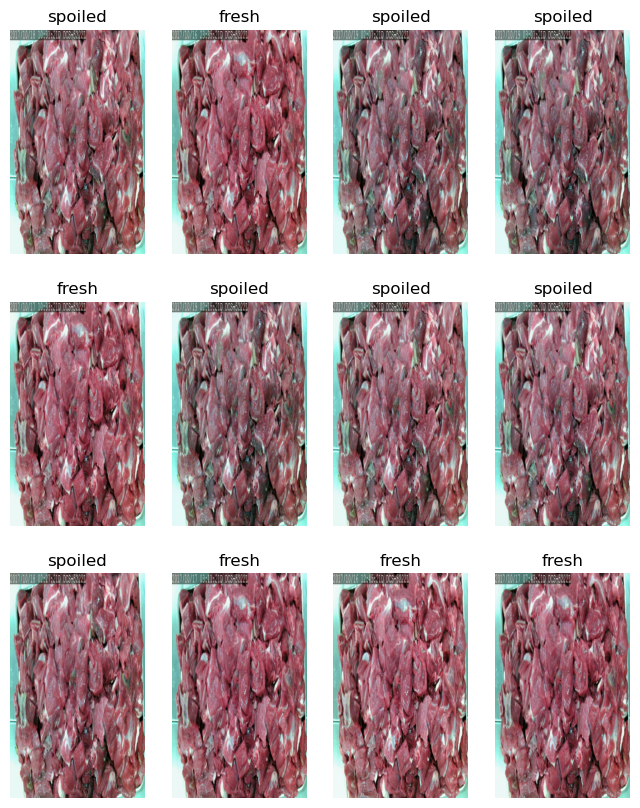

In [24]:
plt.figure(figsize=(8,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# 3. Preprocessing

## Spliting the Data set into Training set, Validation set and Test set

In [25]:
train_size = 0.8
len(dataset) * train_size

40.0

In [26]:
train_ds = dataset.take(40)
len(train_ds)

40

In [27]:
test_ds = dataset.skip(40)
len(test_ds)

10

In [28]:
val_size = 0.1
len(dataset) * val_size

5.0

In [29]:
test_ds = test_ds.skip(5)
len(test_ds)

5

In [30]:
# Let´s create a function to split the dataset into training, validation and test
def get_dataset_participation_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_participation_tf(dataset)

In [32]:
len(train_ds)

40

In [33]:
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 1200, 720, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [34]:
len(val_ds)

5

In [35]:
len(test_ds)

5

In [36]:
# Let´s prepare the  three datasets, train_ds, val_ds, and test_ds for training a machine learning model.
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Feature Scalling and Data Argumentation

__Feature Scalling__
> Feature scaling is a technique used in machine learning to normalize the values of the features (i.e., input variables) to a similar scale. This is important because some machine learning algorithms are sensitive to the scale of the input features. For example, if one feature has a much larger scale than the other features, it can dominate the learning process, and the algorithm may not perform well.

>Put every image in the same size and scale

In [37]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(100,100),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

__Data Argumentation__
> Data augmentation is a technique used in machine learning and computer vision to increase the amount of training data by creating new data from the existing data. The idea behind data augmentation is to generate new examples of training data by applying various transformations to the existing training examples, such as flipping, cropping, rotating, scaling, or adding noise.

>By applying these transformations, the model can learn to be more robust to variations in the input data and improve its ability to generalize to new, unseen data. Data augmentation is particularly useful in situations where the amount of available training data is limited or when the data is imbalanced.

In [38]:
data_argumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# 4. Model Bulding - CNN Model

In [39]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1200, 720, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [58]:
#Let´s create a model using a relu activation function in the input, with 5 layers in the Pooling, a layer Flatenning with relu activation function and a outout layer dense with softmax activation function
input_shape = ( BATCH_SIZE,IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_argumentation,
    #Input layer
    layers.Conv2D(35, (3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    #Pooling
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
   
    #Flatenning
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    #Output LAyer
    layers.Dense(n_classes, activation="softmax")
])

In [59]:
model.build(input_shape=input_shape)

In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 98, 98, 35)        980       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 49, 49, 35)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 47, 47, 64)        20224     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                  

In [61]:
# Let´s define the optimer as adam function, and accuracy as our metric
model.compile(
optimizer="adam",
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=["accuracy"])

# 5. Training the CNN Model

In [62]:
history = model.fit(
train_ds,
epochs=EPOCHS,
verbose=1,
batch_size = BATCH_SIZE,
validation_data=val_ds)

Epoch 1/10
40/40 [==============================] - 18s 236ms/step - loss: 0.6934 - accuracy: 0.5337 - val_loss: 0.6858 - val_accuracy: 0.5200
Epoch 2/10
40/40 [==============================] - 9s 213ms/step - loss: 0.6586 - accuracy: 0.6187 - val_loss: 0.6725 - val_accuracy: 0.5700
Epoch 3/10
40/40 [==============================] - 8s 208ms/step - loss: 0.4642 - accuracy: 0.8188 - val_loss: 0.2335 - val_accuracy: 0.9500
Epoch 4/10
40/40 [==============================] - 8s 212ms/step - loss: 0.2201 - accuracy: 0.9187 - val_loss: 0.1291 - val_accuracy: 0.9400
Epoch 5/10
40/40 [==============================] - 8s 205ms/step - loss: 0.2525 - accuracy: 0.9162 - val_loss: 0.1707 - val_accuracy: 0.9600
Epoch 6/10
40/40 [==============================] - 8s 200ms/step - loss: 0.1813 - accuracy: 0.9375 - val_loss: 0.0466 - val_accuracy: 0.9900
Epoch 7/10
40/40 [==============================] - 8s 208ms/step - loss: 0.1409 - accuracy: 0.9538 - val_loss: 0.0989 - val_accuracy: 0.9500
Epoch

In [63]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 0s 82ms/step - loss: 0.1217 - accuracy: 0.9700


In [64]:
scores

[0.12172266840934753, 0.9700000286102295]

In [65]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

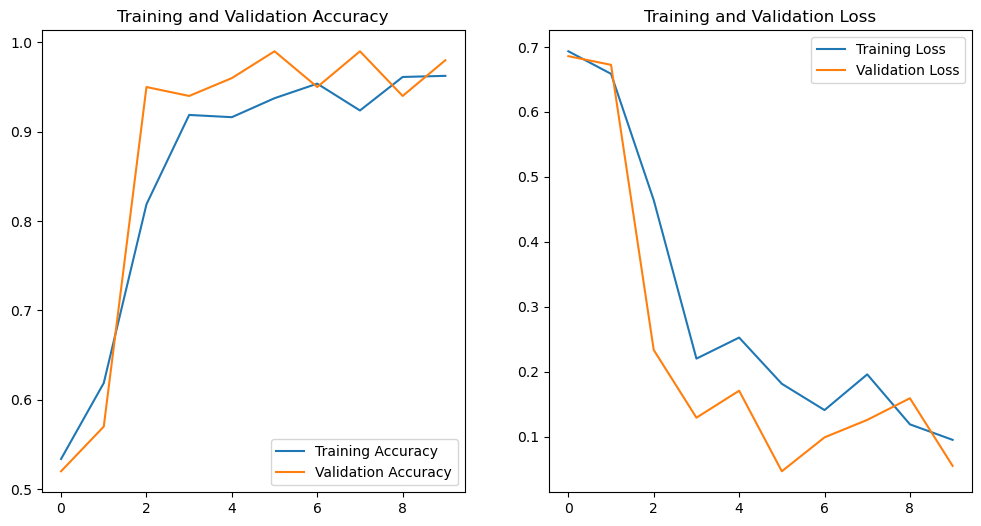

In [84]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

# 6. Test the Model

first image to predict
actual label: spoiled
1/1 [==============================] - 1s 1s/step
prediction label: spoiled


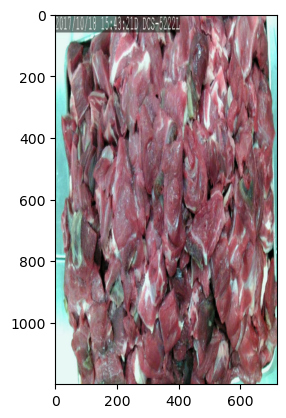

In [68]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("prediction label:", class_names[np.argmax(batch_prediction[0])])

In [74]:
# function to predict returning the confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 71ms/step


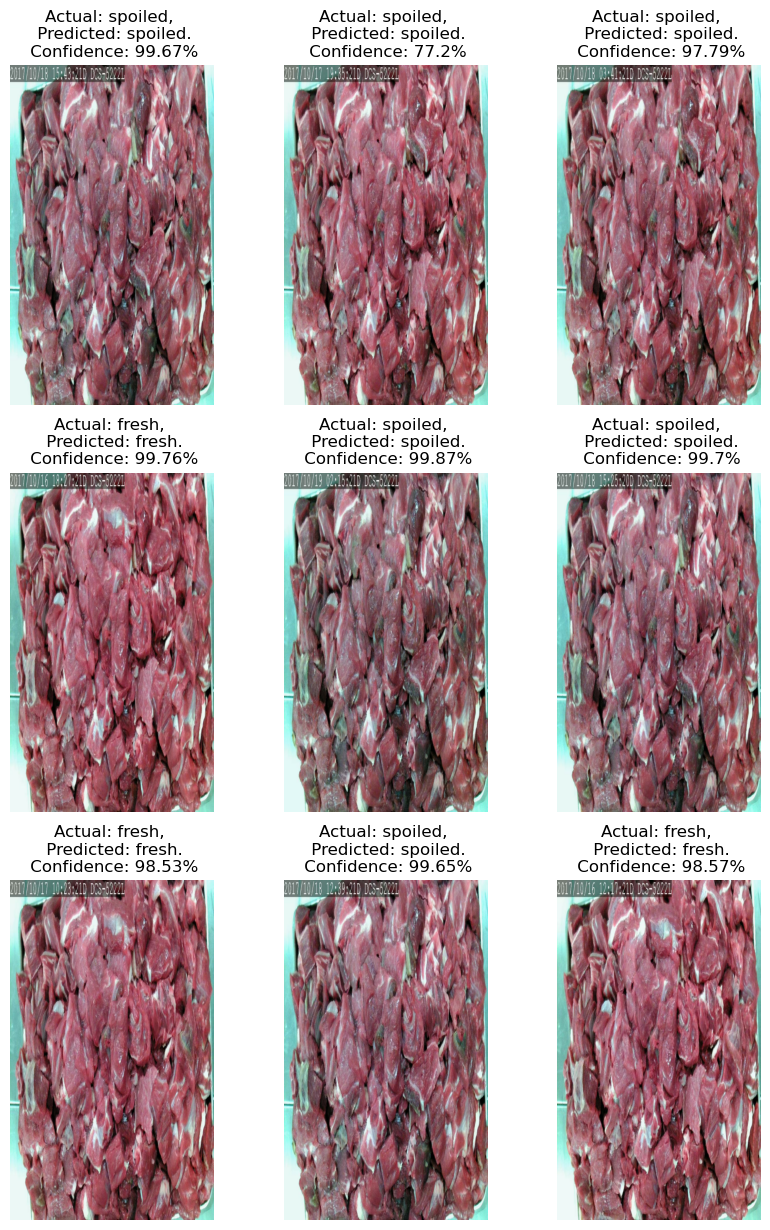

In [80]:
# Let´s do some predictions
plt.figure(figsize=(10,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# 7. Save the Model

In [81]:
model_version="first_model"
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/first_model\assets


INFO:tensorflow:Assets written to: ../models/first_model\assets
